In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import gseapy

# use anaconda/miniconda to ensure packages are right version, otherwise plotting might give error for color

## Load data

In [2]:
adata = sc.read_csv("data/GSM3399102_rawCounts.csv.gz").T

The raw UMI counts from Cell Ranger was processed by the Seurat R package (version 1.4) (Butler et al., 2018; Macosko et al., 2015). Genes that were detected in less than three cells were removed. Cells in which over 5% of the UMIs were mapped to the mitochondrial genes were discarded, and cells that contained less than 200 or over 4800 genes were considered outliers and discarded. Library-size normalization was performed on the UMI-collapsed gene expression for each barcode by scaling the total number of transcripts per cell to 10,000. The data were then log2 transformed. In total, 9,306 cells and 15,823 genes (an average of 1200 detected genes/cell) were used in the cell type determination.

Linear regression was used to regress out the total number of UMIs and the fraction of mitochondrial transcript content per cell. The variable genes were identified using Seurat’s MeanVarPlot function using the following parameters: x.low.cutoff = 0.0; y.cutoff = 0.8, resulting in 1945 variable genes. These variable genes were used in the principal component analysis. The first 23 principal components were used for cell clustering with a resolution at 0.6, and low dimensional reduction to visualize cell clusters. Specific genes for each cluster were identified using the Seurat’s FindAllMarkers function. To refine clustering, the SubsetData function was used to create a new Seurat object containing only a subset of the original cells and cell clustering was reiterated.



In [3]:
# filter genes expressed in less than 3 ells
sc.pp.filter_genes(adata, min_cells=3)

## 1. Quality control

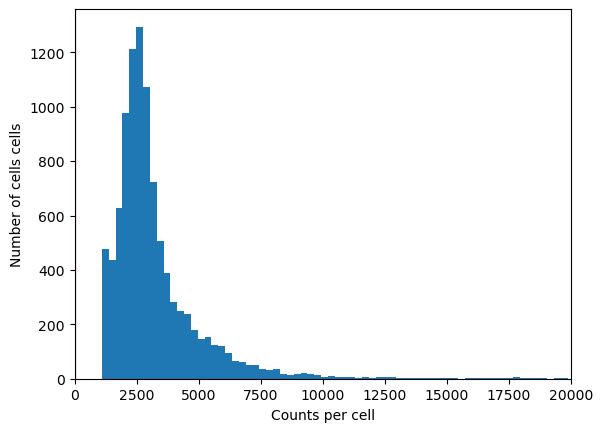

In [4]:
adata.obs['n_counts'] = adata.X.sum(axis=1)
plt.hist(adata.obs['n_counts'], bins=100)
plt.xlabel("Counts per cell") # what are you plotting on the x-axis? Label it!
plt.ylabel("Number of cells cells") # what are you plotting on the x-axis? Label it!
plt.axvline(0, c="r") # specify the lower cutoff value for total UMIs
plt.axvline(0, c="r") # specify the upper cutoff value for total UMIs
plt.xlim(0, 20000)
plt.show()

From the plot, the data is already filtered for UMI counts per cell

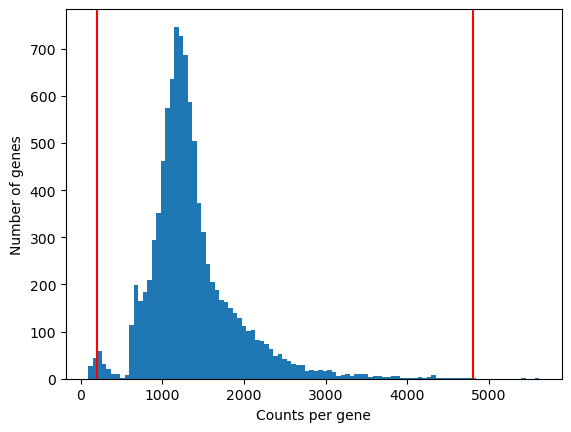

In [5]:
# look at gene counts per gene
expressed_genes = np.sum(adata.X > 0, 1)
adata.obs['n_genes'] = expressed_genes

plt.hist(adata.obs['n_genes'], bins=100)
plt.axvline(200, c="r") # specify the lower cutoff for number of detected genes
plt.axvline(4800, c="r") # specify the upper cutoff for number of detected genes
plt.xlabel("Counts per gene") # what are you plotting on the x-axis? Label it!
plt.ylabel("Number of genes") # what are you plotting on the x-axis? Label it!
plt.show()

c:\Users\jurri\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jurri\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jurri\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jurri\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is

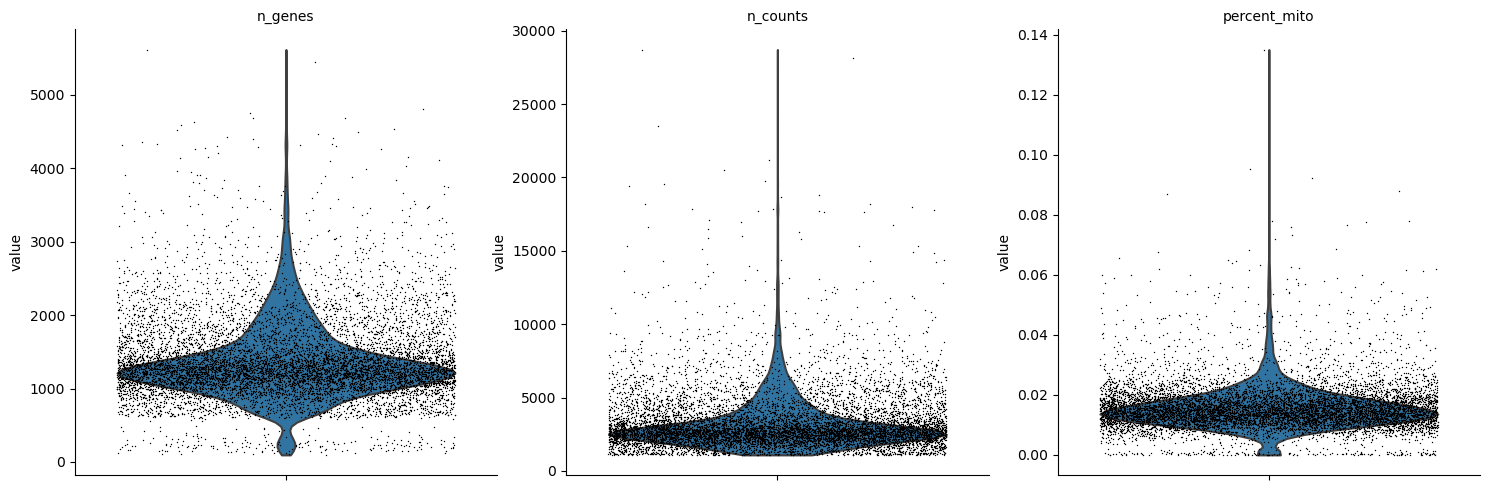

In [6]:
# finally check percentage of mitochondrial genes
mito_genes = adata.var_names.str.startswith('mt-')
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True)

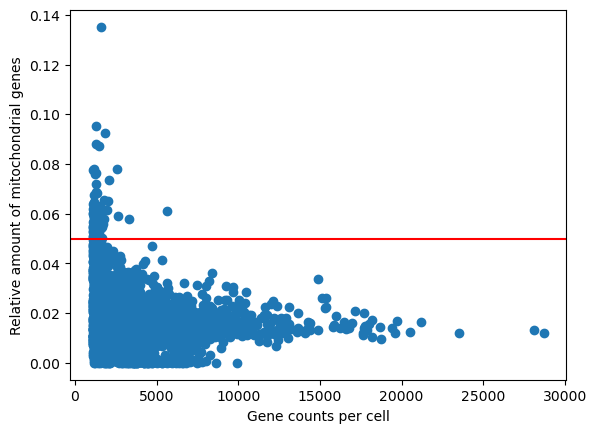

In [7]:
plt.scatter(adata.obs["n_counts"], adata.obs["percent_mito"])
plt.xlabel("Gene counts per cell") # specify the lower cutoff for number of detected genes
plt.ylabel("Relative amount of mitochondrial genes") # specify the lower cutoff for number of detected genes
plt.axhline(0.05, c='red') # specify a threshold (decimal from 0 to 1) for percentage mitochondrial reads
plt.show()

## 1.1 filter the data
Based on the above plots, we suggest to cut-off data for higher than 0.04 mitochondrial percentage,and to keep data within 500 and 3500 counts per gene and 1000to 10,000 gene counts per cell.
To improve, set boundaries with some algorithm based on the distributions?

In [8]:
sc.pp.filter_cells(adata, min_genes=200) # apply threshold from above to actually do the filtering
sc.pp.filter_cells(adata, max_genes=4800) # apply threshold from above to actually do the filtering
adata = adata[adata.obs['percent_mito'] < 0.05, :].copy() # apply threshold from above to actually do the filtering

In [9]:
adata

AnnData object with n_obs × n_vars = 9708 × 15828
    obs: 'n_counts', 'n_genes', 'percent_mito'
    var: 'n_cells'

## 2. Normalization
Address variability caused by sc sequencing process

In [10]:
adata.raw = adata.copy()
adata_raw = adata.copy()

In [11]:
sc.pp.normalize_total(adata, target_sum=10000)
sc.pp.log1p(adata)

## 3. Feature selection

In [12]:
# Get cell states (S, G2m vs G1, G0)
S_genes_mouse = ['Mcm5', 'Pcna', 'Tyms', 'Fen1', 'Mcm2', 'Mcm4', 'Rrm1', 'Ung',
       'Gins2', 'Mcm6', 'Cdca7', 'Dtl', 'Prim1', 'Uhrf1', 'Cenpu',
       'Hells', 'Rfc2', 'Rpa2', 'Nasp', 'Rad51ap1', 'Gmnn', 'Wdr76',
       'Slbp', 'Ccne2', 'Ubr7', 'Pold3', 'Msh2', 'Atad2', 'Rad51', 'Rrm2',
       'Cdc45', 'Cdc6', 'Exo1', 'Tipin', 'Dscc1', 'Blm', 'Casp8ap2',
       'Usp1', 'Clspn', 'Pola1', 'Chaf1b', 'Brip1', 'E2f8']
G2M_genes_mouse = ['Hmgb2', 'Cdk1', 'Nusap1', 'Ube2c', 'Birc5', 'Tpx2', 'Top2a',
       'Ndc80', 'Cks2', 'Nuf2', 'Cks1b', 'Mki67', 'Tmpo', 'Cenpf',
       'Tacc3', 'Pimreg', 'Smc4', 'Ccnb2', 'Ckap2l', 'Ckap2', 'Aurkb',
       'Bub1', 'Kif11', 'Anp32e', 'Tubb4b', 'Gtse1', 'Kif20b', 'Hjurp',
       'Cdca3', 'Jpt1', 'Cdc20', 'Ttk', 'Cdc25c', 'Kif2c', 'Rangap1',
       'Ncapd2', 'Dlgap5', 'Cdca2', 'Cdca8', 'Ect2', 'Kif23', 'Hmmr',
       'Aurka', 'Psrc1', 'Anln', 'Lbr', 'Ckap5', 'Cenpe', 'Ctcf', 'Nek2',
       'G2e3', 'Gas2l3', 'Cbx5', 'Cenpa']

sc.tl.score_genes_cell_cycle(adata, s_genes=S_genes_mouse, g2m_genes=G2M_genes_mouse)

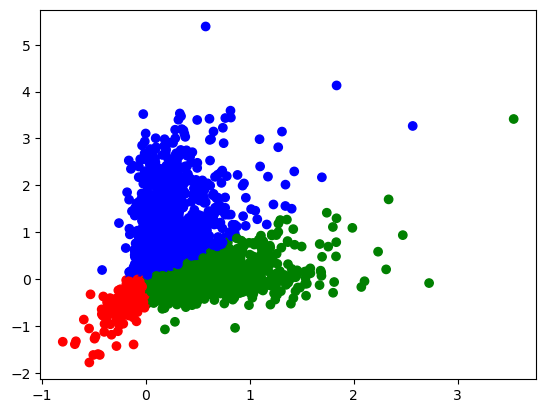

In [13]:
n2c = {"G1":"red", "S":"green", "G2M":"blue"} # use to assign each cell a color based on phase in the scatter plot
colors = []
for phase in adata.obs['phase']:
    colors.append(n2c[phase])

plt.scatter(adata.obs['S_score'], adata.obs['G2M_score'], c=colors)
plt.show()

In [14]:
adata.obs["phase"].value_counts()

phase
G1     6798
S      1849
G2M    1061
Name: count, dtype: int64

Also regress out the effect of cell phase. Authors did not do this, but seems like a good idea if we want to look at pseudo time. So cell phase does not confound those results, or at least less.

In [15]:
# Linear regression was used to regress out the total number of UMIs and the fraction of mitochondrial transcript content per cell. 
sc.pp.regress_out(adata, ['n_counts', 'percent_mito', 'S_score', 'G2M_score']) # specify which feature from adata.obs you want to regress out, if any

Select 1945 highest variance components, as the authors wrote:
The variable genes were identified using Seurat’s MeanVarPlot function using the following parameters: x.low.cutoff = 0.0; y.cutoff = 0.8, resulting in 1945 variable genes. 

In [16]:
sc.pp.highly_variable_genes(adata, n_top_genes=1945, min_disp=0.5, 
                            max_disp=np.inf, min_mean=0.0125, max_mean=3, span=0.3)

c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


In [17]:
adata = adata[:, adata.var["highly_variable"]].copy() # actually do the filtering

In [18]:
adata

AnnData object with n_obs × n_vars = 9708 × 1945
    obs: 'n_counts', 'n_genes', 'percent_mito', 'S_score', 'G2M_score', 'phase'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

## 4. Principal component analysis

In [19]:
sc.tl.pca(adata, svd_solver='arpack')

c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


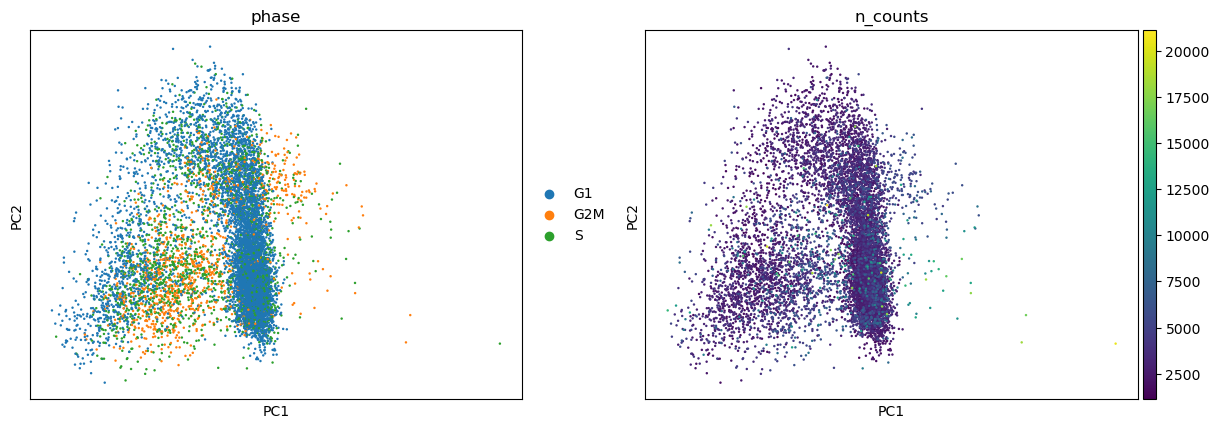

In [20]:
sc.pl.pca(adata, color=['phase','n_counts'])

In [21]:
# above shows a mix for the phase, which is good since it should be regressed out

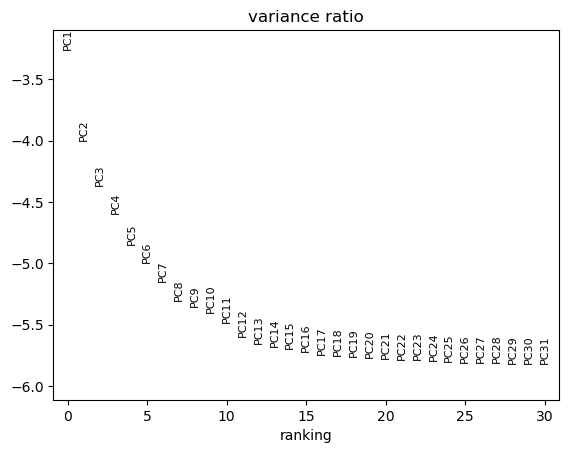

In [22]:
sc.pl.pca_variance_ratio(adata, log=True) # see contribution of each PC to variance

## 5. Dimensionality reduction 

In [23]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=20) # specify the number of neighbors and number of PCs you wish to use

c:\Users\jurri\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
sc.tl.tsne(adata, random_state=0)

c:\Users\jurri\miniconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\jurri\miniconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [25]:
sc.tl.umap(adata, alpha=0.3, min_dist=0.5, random_state=0)

c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


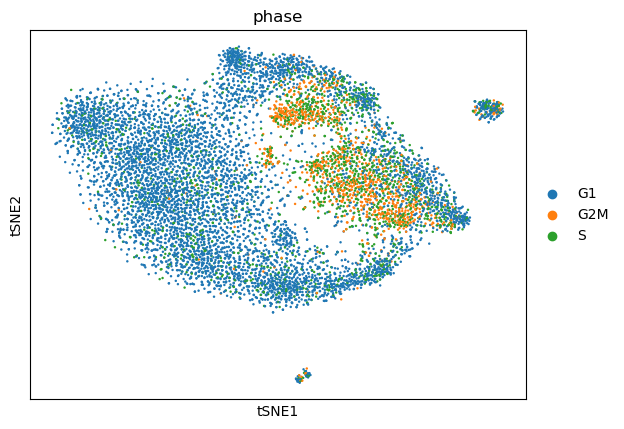

In [26]:
# visualize the tSNE colored by phase
sc.pl.tsne(adata, color='phase', use_raw=False, wspace=0.3, ncols=3)

c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


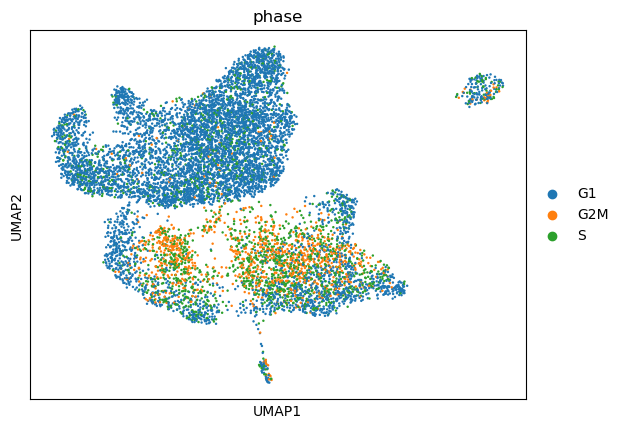

In [27]:
# visualize the UMAP colored by phase
sc.pl.umap(adata, color='phase', use_raw=False, wspace=0.3, ncols=3)

## 6. Clustering

In [28]:
resolution = 1.3
sc.tl.leiden(adata, resolution=resolution)

c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


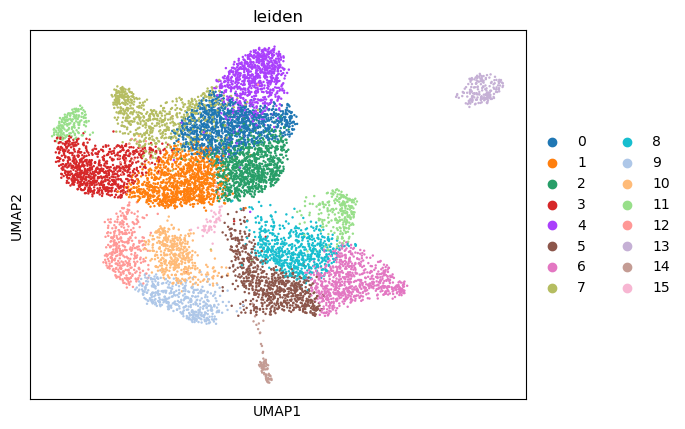

In [29]:
sc.pl.umap(adata, color=['leiden'], use_raw=False, wspace=0.3, ncols=2)

## 7. Identifying marker genes and cell types
Before proceeding with marker gene analysis and cell type annotation, restore the raw version of the data, add the necessary annotations, and normalize the counts:

In [30]:
adata_raw_norm = adata_raw.copy()

# normalize the counts
sc.pp.normalize_total(adata_raw_norm)
# log transform the counts
sc.pp.log1p(adata_raw_norm)
# transfer over the metadata
adata_raw_norm.obsm["X_umap"] = adata.obsm["X_umap"]
adata_raw_norm.obs["leiden"] = [i for i in adata.obs["leiden"]]

In [31]:
sc.tl.rank_genes_groups(adata_raw_norm, 'leiden', use_raw=False, method="t-test")

In [72]:
sc.tl.rank_genes_groups(adata, 'leiden', use_raw=False, method='wilcoxon', key_added = "wilcoxon")


c:\Users\jurri\miniconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning:

c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


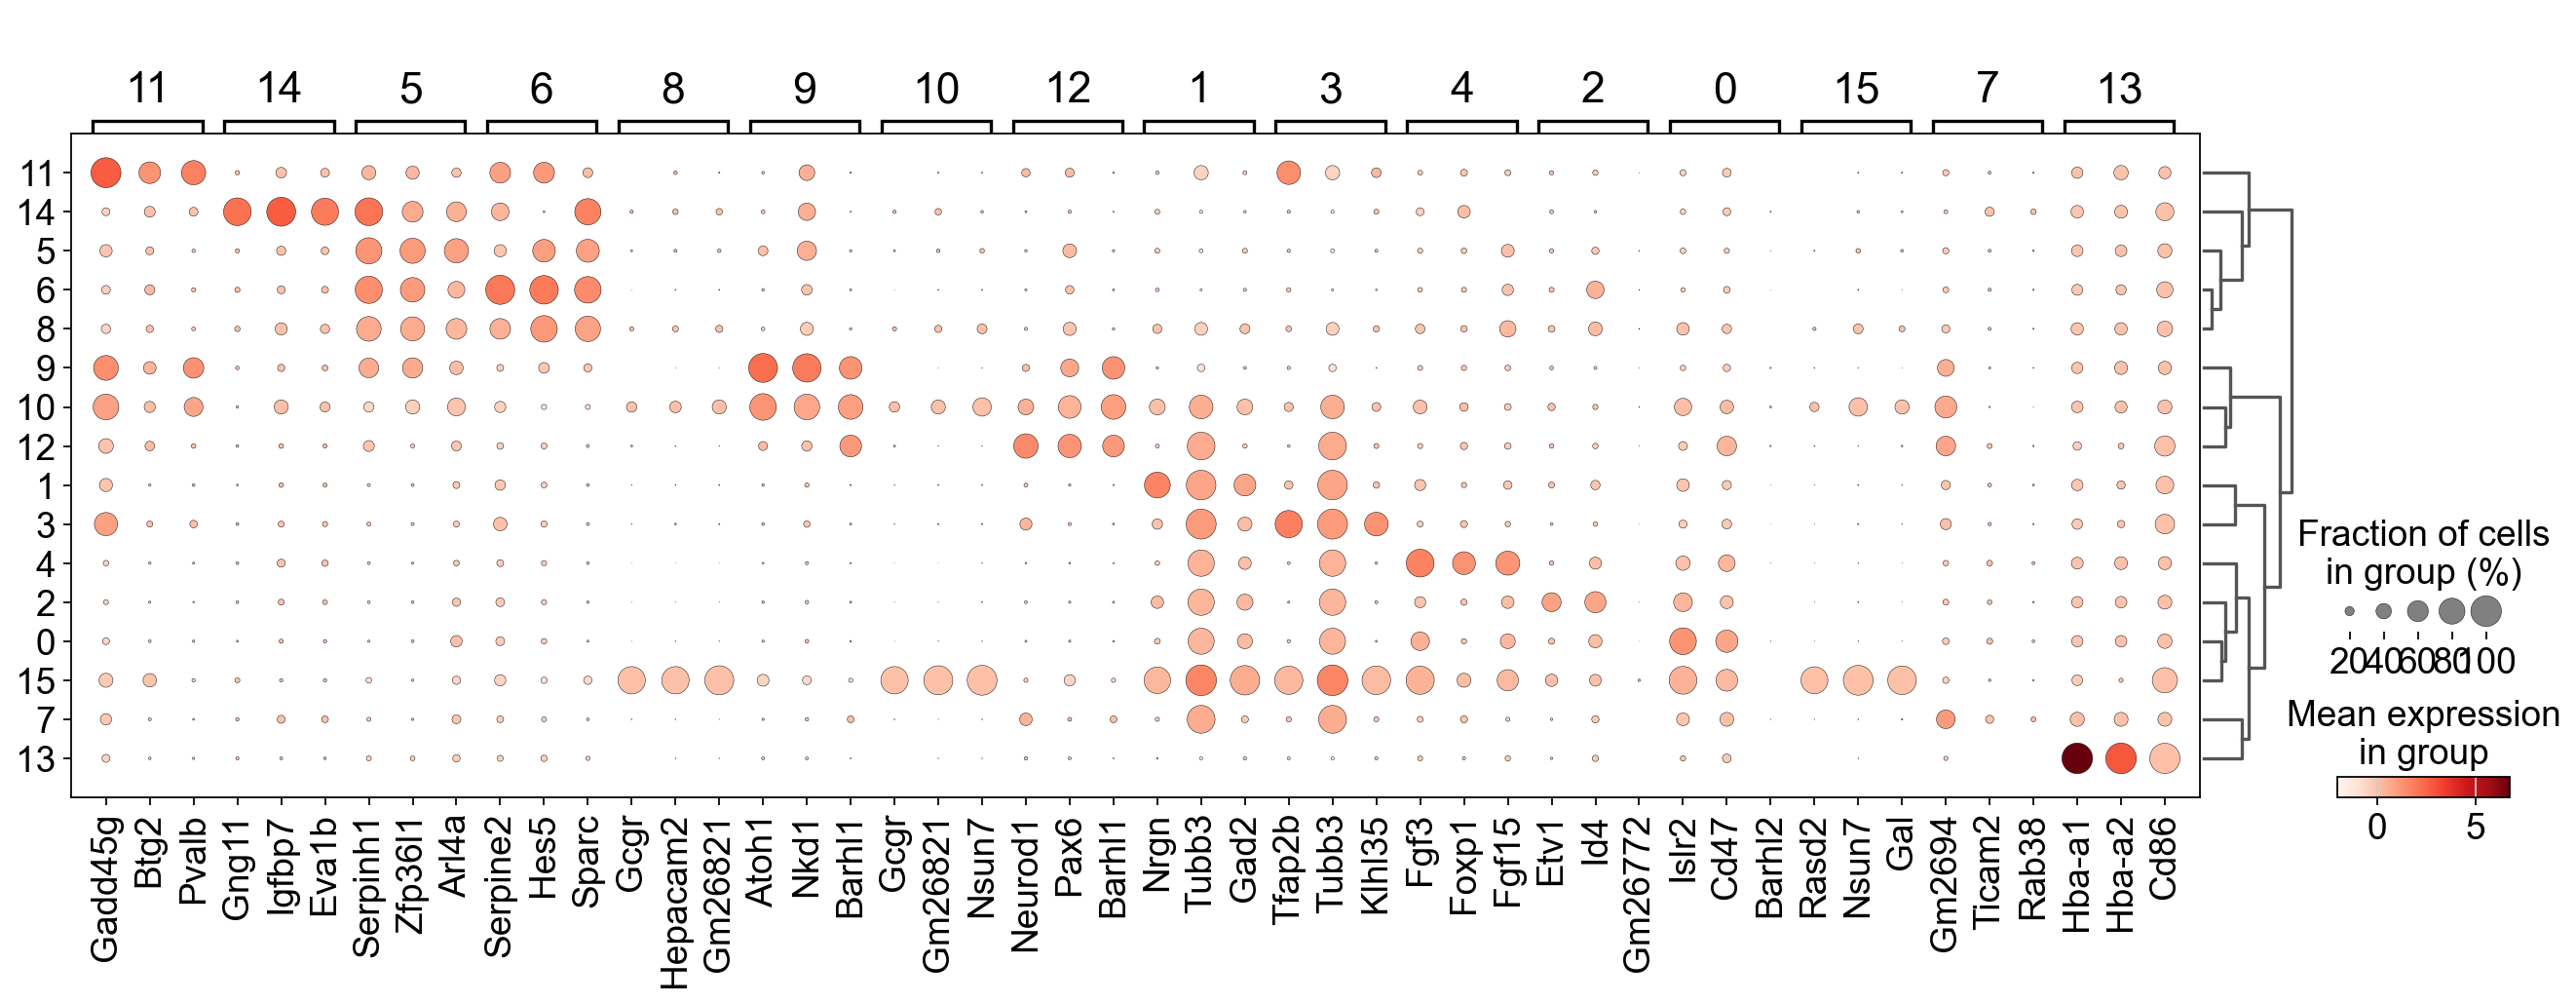

In [75]:
sc.set_figure_params(scanpy=True, fontsize=20) 
sc.pl.rank_genes_groups_dotplot(adata, use_raw=False, n_genes=3, key="wilcoxon", groupby="leiden")


In [33]:
marker_genes = pd.DataFrame(adata_raw_norm.uns["rank_genes_groups"]["names"])
marker_genes.iloc[:100].to_csv("most_variable.csv")

c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_stacked_violin.py:324: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _color_df = _matrix.groupby(level=0).median()
c:\Users\jurri\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jurri\miniconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\jurri\miniconda3\Li

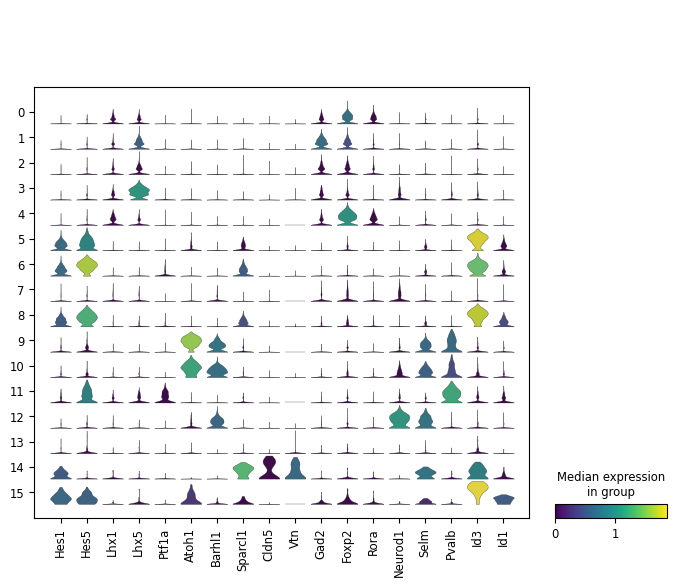

In [34]:
sc.pl.stacked_violin(
    adata_raw_norm, 
    [
        "Hes1", "Hes5", "Lhx1", "Lhx5", "Ptf1a", "Atoh1", 
        "Barhl1", "Sparcl1","Cldn5", "Vtn",
        "Gad2", "Foxp2", "Rora", "Neurod1", "Selm", "Pvalb", "Id3", "Id1"
    ], 
    groupby='leiden', 
    cmap='viridis',
    dendrogram=False,
    rotation=90,
    use_raw=False,
)

In [66]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6802724/ 
cluster2type_dict = {
    "0": "Gabaergic", 
    "1": "Gabaergic",
    "2": "Gabaergic",
    "3": "Gabaergic", 
    "4": "Purkinje",
    "5": "NPC",
    "6": "NPC",
    "7": "Granule neurons",
    "8": "NPC",
    "9": "glutamergic", 
    "10": "glutamergic",
    "11": "NPC gabaergic", 
    "12": "glutamergic",
    "13": "Other",
    "14": "NPC",
    "15": "NPC glutamergic",
}
cell_types = []
for key in cluster2type_dict:
    cell_types.append(cluster2type_dict[key])

In [67]:
adata.obs["cell_type"] = np.array([cluster2type_dict[i] for i in adata.obs["leiden"]])

c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


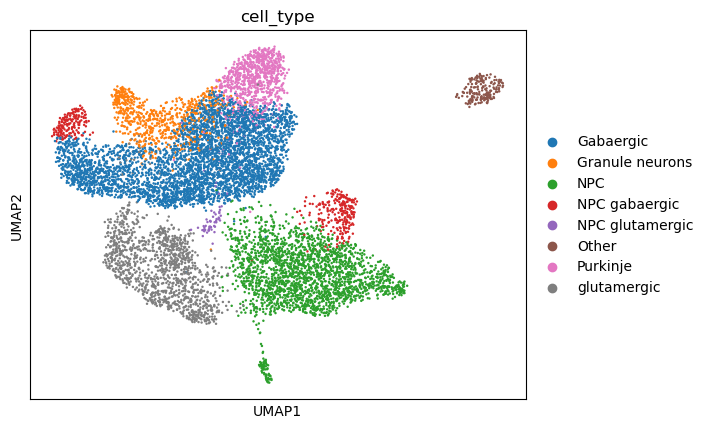

In [68]:
sc.pl.umap(adata, color=['cell_type'], use_raw=False, wspace=0.3, ncols=2)

## 8. Pseudo time analysis

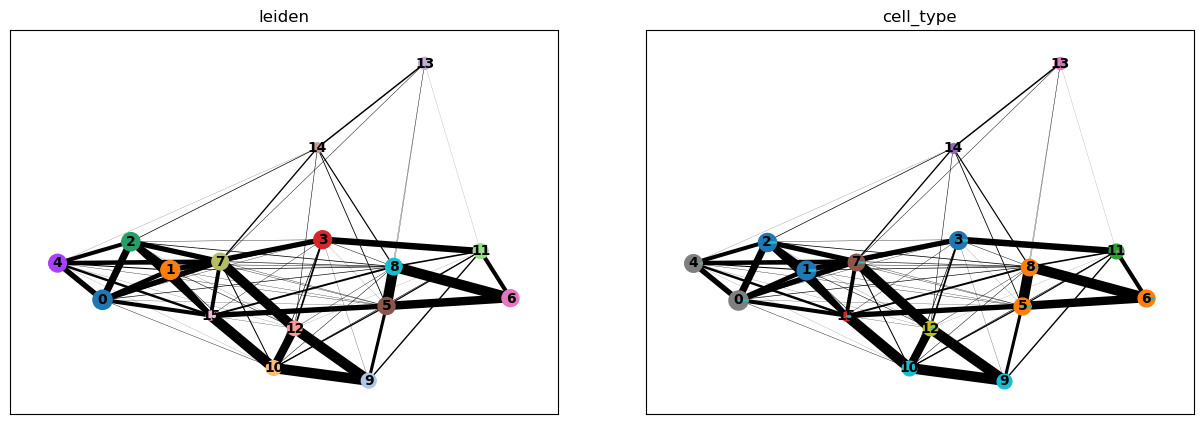

In [38]:
sc.tl.paga(adata, groups='leiden')
sc.pl.paga(adata, color=['leiden', 'cell_type'])


## 8.1 Gabaergic pseudotime


In [64]:
gaba = adata[
    (adata.obs["cell_type"] == "Gabaergic")
    | (adata.obs["cell_type"] == "Purkinje")
    | (adata.obs["cell_type"] == "NPC gabaergic"), :]

C:\Users\jurri\AppData\Local\Temp\ipykernel_47716\3698636052.py:2: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  gaba.uns['iroot'] = np.flatnonzero(gaba.obs['cell_type']  == 'NPC gabaergic')[4]
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


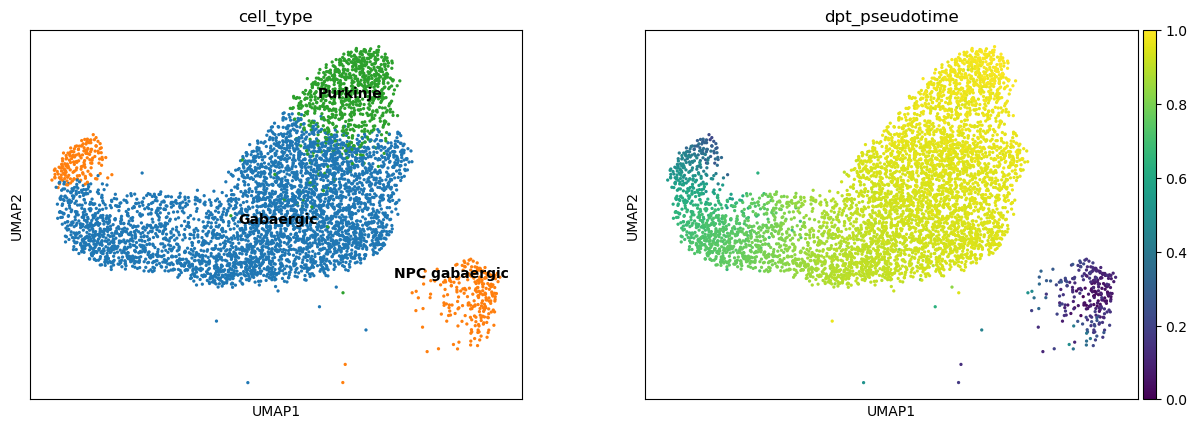

In [65]:
# Choose a root cel for diffusion
gaba.uns['iroot'] = np.flatnonzero(gaba.obs['cell_type']  == 'NPC gabaergic')[4]
sc.tl.diffmap(gaba)
sc.tl.dpt(gaba)
sc.pl.umap(gaba, color=['cell_type', 'dpt_pseudotime'], legend_loc='on data')

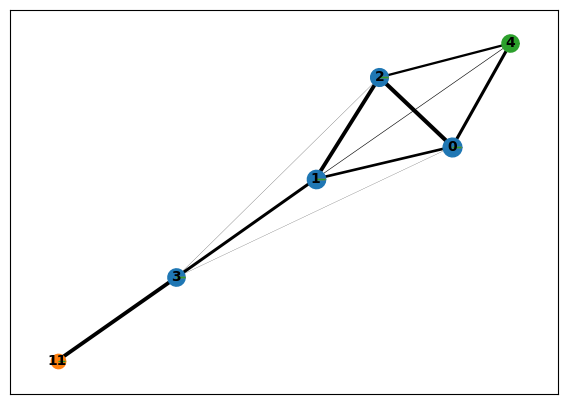

In [70]:
sc.tl.paga(gaba, groups='leiden')
sc.pl.paga(gaba, color=['cell_type'])

## 8.3 Do differential expression between the groups gabaergic groups

In [77]:
gaba.obs['cell_type'].value_counts()
# difference in group size, subsample to equal size

cell_type
Gabaergic        4128
Purkinje          852
NPC gabaergic     413
Name: count, dtype: int64

In [78]:
target_cells = 400
tmp = [gaba[gaba.obs['cell_type'] == s] for s in gaba.obs['cell_type'].cat.categories]

for dat in tmp:
    if dat.n_obs > target_cells:
         sc.pp.subsample(dat, n_obs=target_cells)

gaba_sub_sampled = tmp[0].concatenate(*tmp[1:])
gaba_sub_sampled.obs['cell_type'].value_counts()

C:\Users\jurri\AppData\Local\Temp\ipykernel_47716\4197516551.py:8: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  gaba_sub_sampled = tmp[0].concatenate(*tmp[1:])


cell_type
Gabaergic        400
NPC gabaergic    400
Purkinje         400
Name: count, dtype: int64

In [79]:
sc.tl.rank_genes_groups(gaba_sub_sampled , 'cell_type', use_raw=False, method='wilcoxon', key_added = "wilcoxon")

c:\Users\jurri\miniconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


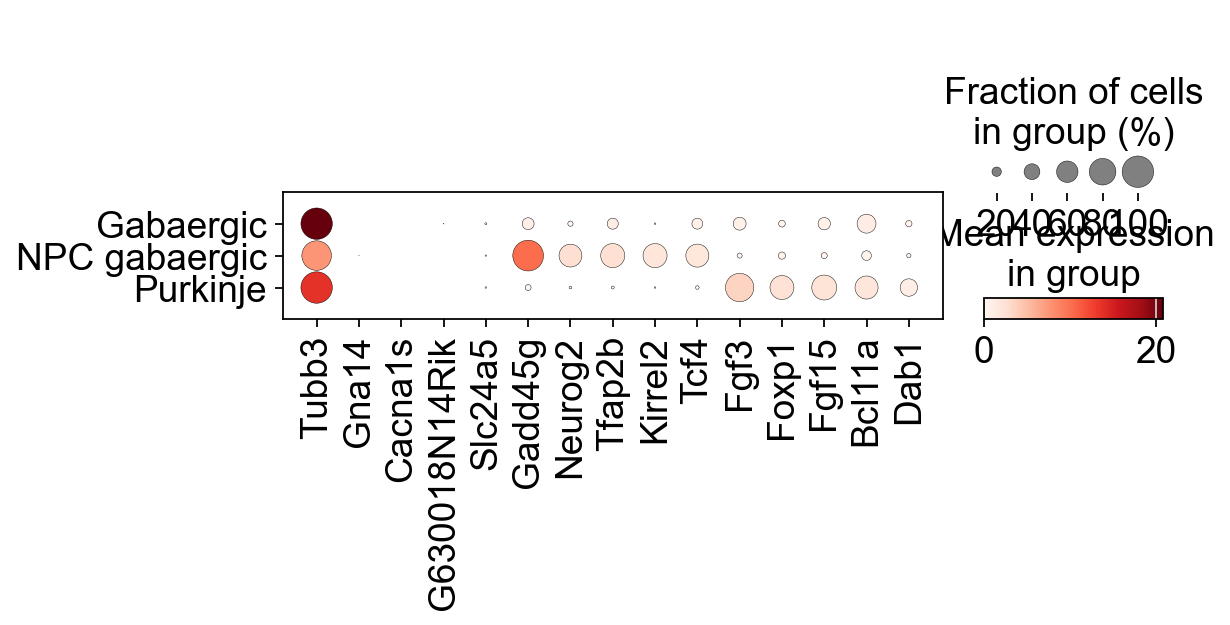

In [80]:
gaba_genes = []
for cat in gaba_sub_sampled.obs["cell_type"].unique():
    gaba_genes += sc.get.rank_genes_groups_df(gaba_sub_sampled, group=cat, key='wilcoxon')['names'][:5].tolist()

sc.pl.dotplot(gaba_sub_sampled,gaba_genes, groupby='cell_type')

## 8.4 Compare NPC to purkinje

In [148]:
purkinje_vs_npc = gaba_sub_sampled[
    (gaba_sub_sampled.obs["cell_type"] == "Purkinje")
    | (gaba_sub_sampled.obs["cell_type"] == "NPC gabaergic"), :]

c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


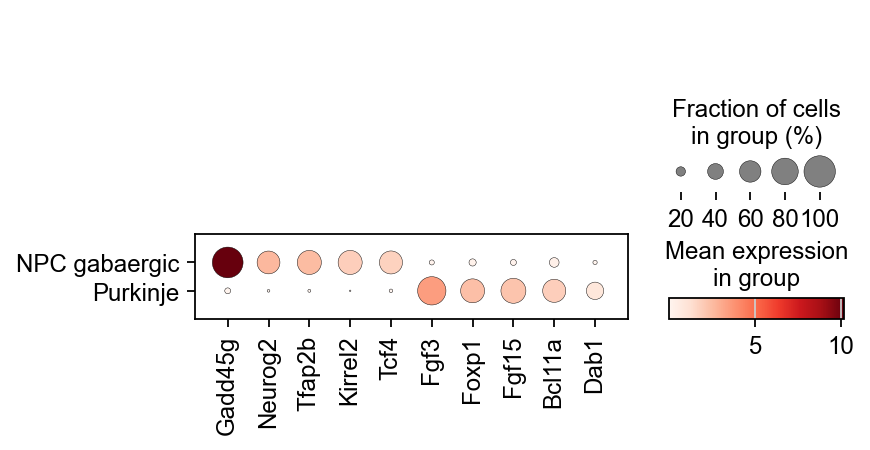

In [162]:
gaba_genes = []
for cat in purkinje_vs_npc.obs["cell_type"].unique():
    gaba_genes += sc.get.rank_genes_groups_df(purkinje_vs_npc, group=cat, key='wilcoxon')['names'][:5].tolist()

sc.set_figure_params(scanpy=True, fontsize=13) 
sc.pl.dotplot(purkinje_vs_npc,gaba_genes, groupby='cell_type')


In [149]:
# get gene lists of interest
comparments = {}
processes = {}
for cat in purkinje_vs_npc.obs["cell_type"].unique():
    glist = sc.get.rank_genes_groups_df(purkinje_vs_npc, group=cat, 
                                    key='wilcoxon', log2fc_min=0.5, 
                                    pval_cutoff=0.05)['names'].squeeze().str.strip().tolist()
    print(f"For category {cat} consider {len(glist)} genes")
    if glist:
        comparments[cat] = gseapy.enrichr(gene_list=glist,
                        organism='Mouse',
                        gene_sets='GO_Cellular_Component_2023',
                        background=purkinje_vs_npc.var.index.to_list(),
                        cutoff = 0.5)
        processes[cat] = gseapy.enrichr(gene_list=glist,
                        organism='Mouse',
                        gene_sets='GO_Biological_Process_2023',
                         background=purkinje_vs_npc.var.index.to_list(),
                        cutoff = 0.5)
    

For category NPC gabaergic consider 215 genes
For category Purkinje consider 92 genes


In [164]:
comparments["Purkinje"].results.head(10)

,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Cellular_Component_2023,Filopodium (GO:0030175),0.009649,0.424981,0,0,8.889246,41.254170,VCAM1;TUBB3;PDPN
1,GO_Cellular_Component_2023,Actin-Based Cell Projection (GO:0098858),0.012818,0.424981,0,0,7.773876,33.870177,VCAM1;TUBB3;PDPN
2,GO_Cellular_Component_2023,Polymeric Cytoskeletal Fiber (GO:0099513),0.036658,0.424981,0,0,4.770959,15.773377,AKNA;TUBB3;GAS2
3,GO_Cellular_Component_2023,Microvillus (GO:0005902),0.039794,0.424981,0,0,8.213333,26.480055,VCAM1;PDPN
4,GO_Cellular_Component_2023,Primary Lysosome (GO:0005766),0.047301,0.424981,0,0,inf,inf,HEXB
5,GO_Cellular_Component_2023,Cortical Granule (GO:0060473),0.047301,0.424981,0,0,inf,inf,HEXB
6,GO_Cellular_Component_2023,Muscle Myosin Complex (GO:0005859),0.047301,0.424981,0,0,inf,inf,MYL9
7,GO_Cellular_Component_2023,Pericentric Heterochromatin (GO:0005721),0.047301,0.424981,0,0,inf,inf,CHRAC1
8,GO_Cellular_Component_2023,Pi-Body (GO:0071546),0.047301,0.424981,0,0,inf,inf,TDRKH
9,GO_Cellular_Component_2023,Filopodium Membrane (GO:0031527),0.047301,0.424981,0,0,inf,inf,PDPN


In [165]:
comparments["NPC gabaergic"].results.head(10)

0       Bicellular Tight Junction (GO:0005923)
1                        Lysosome (GO:0005764)
2         Apical Junction Complex (GO:0043296)
3                  Tight Junction (GO:0070160)
4        Organelle Outer Membrane (GO:0031968)
5                 Catenin Complex (GO:0016342)
6               Neuron Projection (GO:0043005)
7    Mitochondrial Outer Membrane (GO:0005741)
8                            Axon (GO:0030424)
9           Glutamatergic Synapse (GO:0098978)
Name: Term, dtype: object

In [116]:
top_terms = {}
for group in comparments:
    top_terms[group] = comparments[group].results[:10]["Term"]
unique_comparments = {}
for group_i in top_terms:
    unique = top_terms[group_i]
    for group_j in top_terms:
        if group_i !=group_j:
            for item in top_terms[group_j]:
                if item in unique:
                    unique = unique.remove(item)
    unique_comparments[group_i] = unique

In [117]:
pd.DataFrame(unique_comparments)

,Gabaergic,NPC gabaergic,Purkinje
0,Intracellular Organelle Lumen (GO:0070013),Lysosome (GO:0005764),Filopodium (GO:0030175)
1,Actin Cytoskeleton (GO:0015629),Bicellular Tight Junction (GO:0005923),Actin-Based Cell Projection (GO:0098858)
2,Cytoskeleton (GO:0005856),Lytic Vacuole Membrane (GO:0098852),Microvillus (GO:0005902)
3,Mitochondrial Matrix (GO:0005759),Cytoplasmic Vesicle Membrane (GO:0030659),Adherens Junction (GO:0005912)
4,Collagen-Containing Extracellular Matrix (GO:0...,Lytic Vacuole (GO:0000323),Nucleus (GO:0005634)
5,cyclin/CDK Positive Transcription Elongation F...,Lipid Droplet (GO:0005811),Muscle Myosin Complex (GO:0005859)
6,Endocytic Vesicle Membrane (GO:0030666),Apical Junction Complex (GO:0043296),Filopodium Membrane (GO:0031527)
7,Extracellular Membrane-Bounded Organelle (GO:0...,Tight Junction (GO:0070160),Intracellular Membrane-Bounded Organelle (GO:0...
8,Extracellular Vesicle (GO:1903561),Endosome Membrane (GO:0010008),Mitotic Spindle (GO:0072686)
9,Cytoplasmic Vesicle Lumen (GO:0060205),Polymeric Cytoskeletal Fiber (GO:0099513),Cell-Cell Junction (GO:0005911)


# END

## NPC pseudo time

In [ ]:
NPC = adata[
    (adata.obs["cell_type"] == "NPC")
    | (adata.obs["cell_type"] == "NPC Pvalb")
    | (adata.obs["cell_type"] == "NPC glutamergic")
    #| (adata.obs["cell_type"] == "NPC/Astrocytes")
    ,
    :]

C:\Users\jurri\AppData\Local\Temp\ipykernel_7276\1609575589.py:2: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  NPC.uns['iroot'] = np.flatnonzero(NPC.obs['cell_type']  == 'NPC')[4]
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


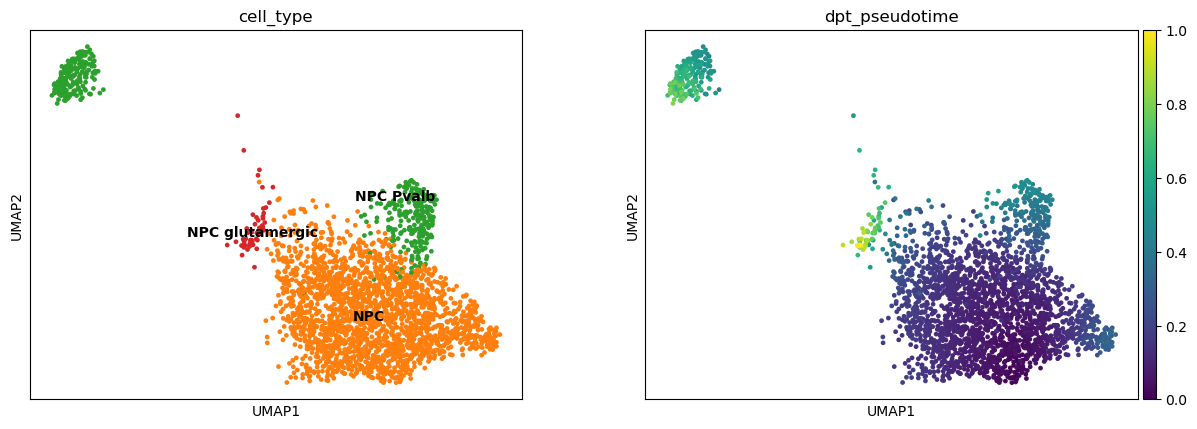

In [ ]:
# Choose a root cel for diffusion
NPC.uns['iroot'] = np.flatnonzero(NPC.obs['cell_type']  == 'NPC')[4]
sc.tl.diffmap(NPC)
sc.tl.dpt(NPC)
sc.pl.umap(NPC, color=['cell_type', 'dpt_pseudotime'], legend_loc='on data')


## glutamergic pseuodtime


C:\Users\jurri\AppData\Local\Temp\ipykernel_7276\2655631524.py:7: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  excitatory.uns['iroot'] = np.flatnonzero(excitatory.obs['cell_type']  == 'NPC glutamergic')[4]
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


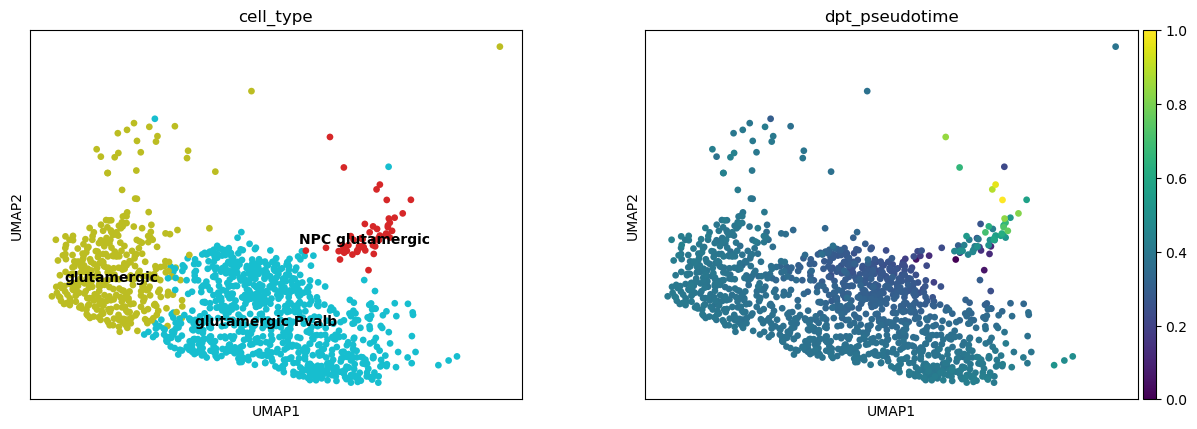

In [ ]:
excitatory = adata[
    (adata.obs["cell_type"] == "NPC glutamergic")
    | (adata.obs["cell_type"] == "glutamergic")
    | (adata.obs["cell_type"] == "glutamergic Pvalb"),
    :]
# Choose a root cel for diffusion
excitatory.uns['iroot'] = np.flatnonzero(excitatory.obs['cell_type']  == 'NPC glutamergic')[4]
sc.tl.diffmap(excitatory)
sc.tl.dpt(excitatory)
sc.pl.umap(excitatory, color=['cell_type', 'dpt_pseudotime'], legend_loc='on data')


## Look at differences between glutamergic clusters

In [ ]:
excitatory.obs['cell_type'].value_counts()
# difference in group size, subsample to equal size

cell_type
glutamergic Pvalb    834
glutamergic          388
NPC glutamergic       57
Name: count, dtype: int64

In [ ]:
target_cells = 50

tmp = [excitatory[excitatory.obs['cell_type'] == s] for s in excitatory.obs['cell_type'].cat.categories]

for dat in tmp:
    if dat.n_obs > target_cells:
         sc.pp.subsample(dat, n_obs=target_cells)

excitatory = tmp[0].concatenate(*tmp[1:])

excitatory.obs['cell_type'].value_counts()

C:\Users\jurri\AppData\Local\Temp\ipykernel_7276\3620743080.py:9: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  excitatory = tmp[0].concatenate(*tmp[1:])


cell_type
NPC glutamergic      50
glutamergic          50
glutamergic Pvalb    50
Name: count, dtype: int64

In [ ]:
sc.tl.rank_genes_groups(excitatory, 'cell_type', use_raw=False, method='wilcoxon', key_added = "wilcoxon")

c:\Users\jurri\miniconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


['1', '3', '2', '11', '7', '4', '0']
Categories (7, object): ['0', '1', '2', '3', '4', '7', '11']

c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


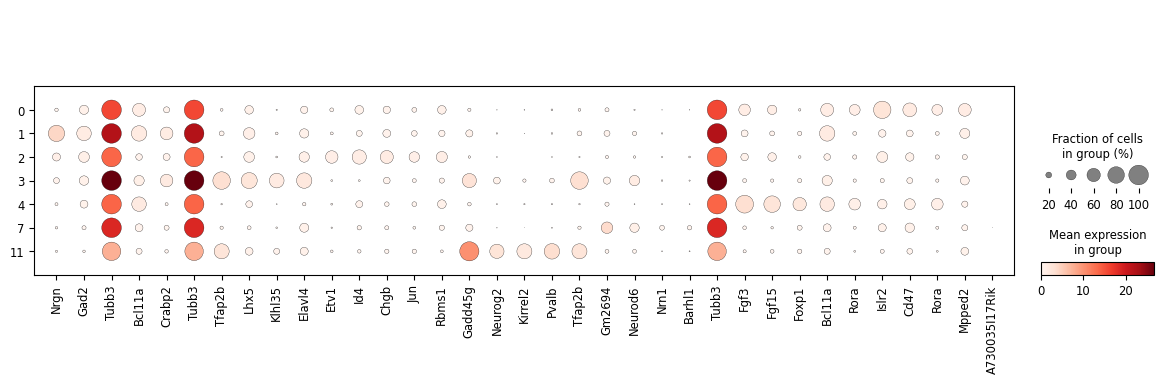

In [ ]:
gaba_genes = []
for cat in gaba_sub_sampled.obs["leiden"].unique():
    gaba_genes += sc.get.rank_genes_groups_df(gaba_sub_sampled, group=cat, key='wilcoxon')['names'][:5].tolist()

sc.pl.dotplot(gaba_sub_sampled,gaba_genes, groupby='leiden')

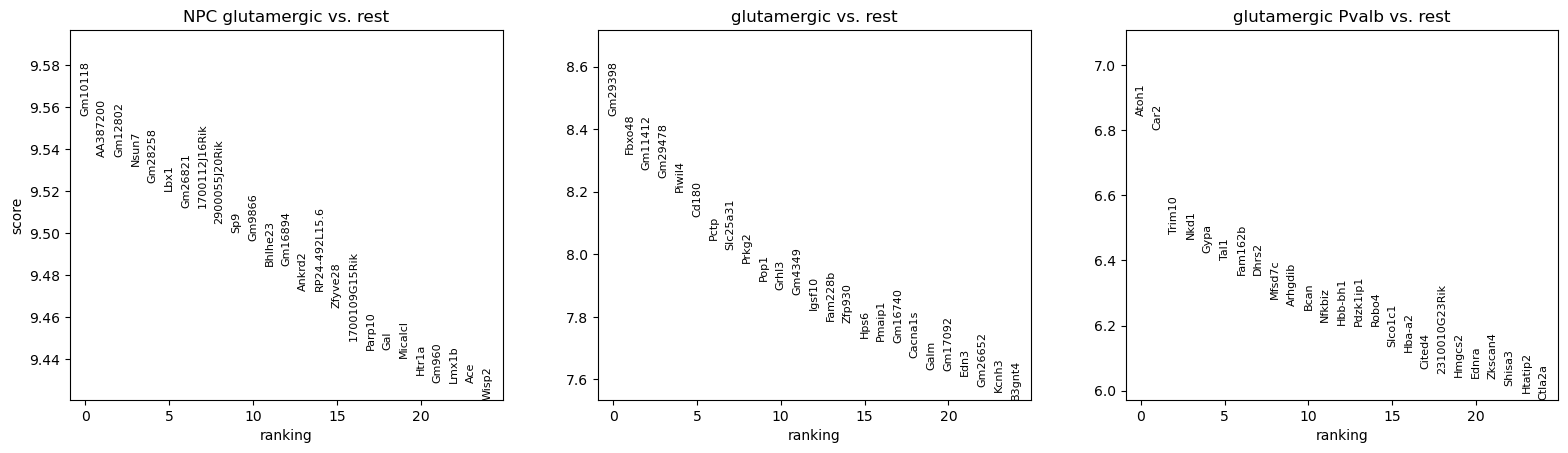

In [ ]:
sc.pl.rank_genes_groups(excitatory, n_genes=25, sharey=False, key="wilcoxon")

c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


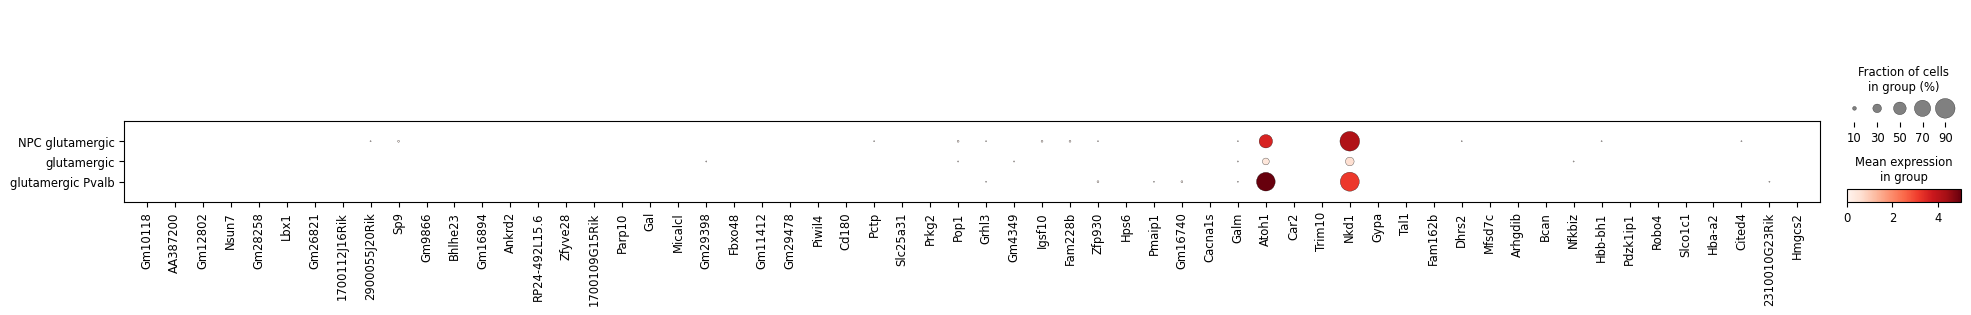

In [ ]:
genes_npc = sc.get.rank_genes_groups_df(excitatory, group='NPC glutamergic', key='wilcoxon')['names'][:20]
genes_glut = sc.get.rank_genes_groups_df(excitatory, group='glutamergic', key='wilcoxon')['names'][:20]
genes_pvalb = sc.get.rank_genes_groups_df(excitatory, group='glutamergic Pvalb', key='wilcoxon')['names'][:20]

genes = genes_npc.tolist() +  genes_glut.tolist() + genes_pvalb.to_list()
sc.pl.dotplot(excitatory,genes, groupby='cell_type')

In [ ]:
#?gseapy.enrichr
glist_pvalb = sc.get.rank_genes_groups_df(excitatory, group='glutamergic Pvalb', 
                                    key='wilcoxon', log2fc_min=2, 
                                    pval_cutoff=0.0005)['names'].squeeze().str.strip().tolist()
print(f"Number of genes considered for the Parvalbumin glutamergic neurons is {len(glist_pvalb)}")

Number of genes considered for the Parvalbumin glutamergic neurons is 14


In [ ]:
enr_res = gseapy.enrichr(gene_list=glist_pvalb,
                     organism='Mouse',
                     gene_sets='GO_Biological_Process_2023',
                     cutoff = 0.5)
#GO_Cellular_Component_2023
#GO_Molecular_Function_2023

In [ ]:
enr_res.results.head(20)


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Cellular_Component_2023,Microfibril (GO:0001527),1/11,0.007675,0.122799,0,0,153.661538,748.300346,MFAP4
1,GO_Cellular_Component_2023,Supramolecular Fiber (GO:0099512),1/36,0.024915,0.127680,0,0,43.848352,161.900435,MFAP4
2,GO_Cellular_Component_2023,Intracellular Membrane-Bounded Organelle (GO:0...,7/5175,0.045511,0.127680,0,0,2.867260,8.859251,BARHL1;HSD11B2;MAGI2;MAFF;OXSR1;LMX1B;INSM1
3,GO_Cellular_Component_2023,Voltage-Gated Potassium Channel Complex (GO:00...,1/73,0.049921,0.127680,0,0,21.275641,63.769860,KCNJ2
4,GO_Cellular_Component_2023,Bicellular Tight Junction (GO:0005923),1/81,0.055249,0.127680,0,0,19.140385,55.428901,MAGI2
5,GO_Cellular_Component_2023,Potassium Channel Complex (GO:0034705),1/81,0.055249,0.127680,0,0,19.140385,55.428901,KCNJ2
6,GO_Cellular_Component_2023,Tight Junction (GO:0070160),1/93,0.063188,0.127680,0,0,16.633779,45.936486,MAGI2
7,GO_Cellular_Component_2023,Apical Junction Complex (GO:0043296),1/106,0.071719,0.127680,0,0,14.564835,38.378242,MAGI2
8,GO_Cellular_Component_2023,Nucleus (GO:0005634),6/4487,0.071820,0.127680,0,0,2.595124,6.834504,BARHL1;MAGI2;MAFF;OXSR1;LMX1B;INSM1
9,GO_Cellular_Component_2023,Asymmetric Synapse (GO:0032279),1/133,0.089208,0.142733,0,0,11.569930,27.961987,MAGI2


In [ ]:
glist_norm = sc.get.rank_genes_groups_df(excitatory, group='glutamergic', 
                                    key='wilcoxon', log2fc_min=2, 
                                    pval_cutoff=0.0005)['names'].squeeze().str.strip().tolist()
print(f"Number of genes considered for the \"normal\" glutamergic neurons is {len(glist_norm)}")


Number of genes considered for the "normal" glutamergic neurons is 134


In [ ]:
enr_norm = gseapy.enrichr(gene_list=glist_norm,
                     organism='Mouse',
                     gene_sets='GO_Cellular_Component_2023',
                     cutoff = 0.5)
#GO_Cellular_Component_2023
#GO_Molecular_Function_2023

In [ ]:
enr_norm.results.head(20)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Cellular_Component_2023,Synaptic Membrane (GO:0097060),2/31,0.018249,0.747431,0,0,10.364159,41.494655,ATP2B2;GRIN1
1,GO_Cellular_Component_2023,Neuron Projection (GO:0043005),8/557,0.034047,0.747431,0,0,2.234019,7.551031,CHRM2;ADCYAP1;TH;CCK;NPTX1;SSTR1;CRHR1;GRIN1
2,GO_Cellular_Component_2023,Spectrin-Associated Cytoskeleton (GO:0014731),1/7,0.045974,0.747431,0,0,24.887218,76.644489,DMTN
3,GO_Cellular_Component_2023,Platelet Dense Tubular Network Membrane (GO:00...,1/8,0.052368,0.747431,0,0,21.330827,62.914212,DMTN
4,GO_Cellular_Component_2023,Platelet Dense Tubular Network (GO:0031094),1/10,0.065030,0.747431,0,0,16.588972,45.336227,DMTN
5,GO_Cellular_Component_2023,Lamellar Body (GO:0042599),1/13,0.083707,0.747431,0,0,12.439850,30.856211,ABCA3
6,GO_Cellular_Component_2023,Chitosome (GO:0045009),1/15,0.095952,0.747431,0,0,10.661654,24.989883,TH
7,GO_Cellular_Component_2023,Melanosome Membrane (GO:0033162),1/15,0.095952,0.747431,0,0,10.661654,24.989883,TH
8,GO_Cellular_Component_2023,Pigment Granule Membrane (GO:0090741),1/15,0.095952,0.747431,0,0,10.661654,24.989883,TH
9,GO_Cellular_Component_2023,Glutamatergic Synapse (GO:0098978),2/78,0.096339,0.747431,0,0,3.945375,9.231706,ATP2B2;NPTX1


In [ ]:
glist_npc = sc.get.rank_genes_groups_df(excitatory, group='glutamergic Pvalb', 
                                    key='wilcoxon', log2fc_min=2, 
                                    pval_cutoff=0.0005)['names'].squeeze().str.strip().tolist()
print(f"Number of genes considered for the \"normal\" glutamergic neurons is {len(glist_norm)}")

Number of genes considered for the "normal" glutamergic neurons is 134


In [ ]:
enr_norm = gseapy.enrichr(gene_list=glist_norm,
                     organism='Mouse',
                     gene_sets='GO_Biological_Process_2023',
                     cutoff = 0.5)
#GO_Cellular_Component_2023
#GO_Molecular_Function_2023